Notebook for data creation for CNN training.
Two different approaches:



1.   CUSTOM DATA CREATION
We used a custom method of classification composed by data preprocessing using PCA transformation and then superclass prediction by SVM Classification. 

2.   PAPER DATA
We used the same division of the paper in order to achieve their results.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MLinApp_project_mine


/content/drive/.shortcut-targets-by-id/1wXg2dci4kAWzFZAvhlShcmwk3t0dUHTP/MLinApp_project_mine


# 0. Data loading and main function declaration

### 0.1. Function import

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
import numpy as np
import pickle as pk  
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import svm
import sklearn.metrics
import csv, pprint
import scipy.stats
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import math
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from numpy import asarray
from numpy import savetxt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC, RandomForestClassifier
from xgboost import XGBClassifier 

random_state = 42
test_size = 0.2

# Change default graph dimension
plt.rcParams['figure.figsize'] = [25, 15] #inches

def label_processing(labels, mapping: dict = None):
    new_miRna_label = []
    
    if mapping == None: mapping = create_dictionary(labels)

    for i in labels:
        new_miRna_label.append(mapping[i])
    return np.array(new_miRna_label)


def create_dictionary(labels):
    dictionary = {}
    class_names = np.unique(labels)
    for i, name in enumerate(class_names):
        dictionary[name] = i
    return dictionary


def extract_label(file_name, verbose=False):
    data = {}
    label = []
    with open(file_name, "r") as fin:
        reader = csv.reader(fin, delimiter=',')
        first = True
        for row in reader:
            lbl = row[2]
            if first or "TARGET" in lbl:
                first = False
                continue
            lbl = lbl.replace("TCGA-","")

            label.append(lbl)
            if lbl in data.keys():
                data[lbl] += 1 
            else:
                data[lbl] = 1
    if verbose:
        print(f"Number of classes in the dataset = {len(data)}")
        pprint.pprint(data, indent=4)
    return label
def ovo_ovr_training(train_data, train_label):
  # OVO
  ovo = SVC(decision_function_shape='ovo')
  ovo.fit(train_data, train_label)
  pk.dump(ovo, open("models/ovo.pkl","wb"))
  # OVR
  ovr = SVC(decision_function_shape='ovr')
  ovr.fit(train_data, train_label)
  pk.dump(ovr, open("models/ovr.pkl","wb"))
  return ovo, ovr
  
  
# Stacking
def metadata_matrix_generator(ovo, ovr, train_data, verbose=False):
  ovo_scores = ovo.decision_function(train_data)
  if verbose==True:
    print(ovo_scores.shape)
  ovr_scores = ovr.decision_function(train_data)
  if verbose==True:
    print(ovr_scores.shape)
  
  metadata_matrix = np.hstack((ovo_scores, ovr_scores))
  if verbose==True:
   print(metadata_matrix.shape)
  return metadata_matrix

def superclass_information(x, n): 
  counter_label = [0 for _ in range(n)]
  for cl in x: 
    counter_label[cl] += 1
  print(f"Number of sample per cluster:")
  for cl in range(n):
    print(f"Cluster {cl}: {counter_label[cl]} element")

# Set to true if you want to train again

def ovo_ovr_training_gb(train_data, train_label, training):
  # OVO
  if training == True:
    ovo_classifier = OneVsOneClassifier(GBC())
    ovo_classifier.fit(train_data, train_label)    
    print("OVO training completed")

    pk.dump(ovo_classifier, open("models/ovo_GBC.pkl","wb"))
  else:
    ovo_classifier = pk.load(open("models/ovo_GBC.pkl",'rb'))
    print("OVO model loaded")
  ovo_ovr = list(ovo_classifier.estimators_)

  # OVR
  if training == True:
    classifier = OneVsRestClassifier(GBC(loss='exponential'))
    classifier.fit(train_data, train_label)
    print("OVR training completed")
    pk.dump(classifier, open("models/ovr_GBC.pkl","wb"))
  else: 
    classifier =  pk.load(open("models/ovr_GBC.pkl",'rb'))
    print("OVR model loaded")

  ovo_ovr = ovo_ovr + classifier.estimators_
  print(len(ovo_ovr))
  return ovo_ovr

def metadata_creation_gb(train_data, train_label, training=False):
  estimators = ovo_ovr_training_gb(train_data, train_label, training)

  metadata_matrix = estimators[0].predict(train_data)
  metadata_matrix = metadata_matrix.reshape((-1, 1))

  for i in range(1,len(estimators)):
    temp = estimators[i].predict(train_data)
    metadata_matrix = np.hstack((metadata_matrix, temp.reshape((-1, 1))))

  return metadata_matrix

def get_even_clusters(X, cluster_size):
  n_clusters = int(np.ceil(len(X)/cluster_size))
  kmeans = KMeans(n_clusters)
  kmeans.fit(X)
  centers = kmeans.cluster_centers_
  centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
  distance_matrix = cdist(X, centers)
  clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
  return clusters


### 0.2. Retrieve and Clean data 

In [ ]:
# Remove the first row and the last column from the feature
miRna_label = np.array(extract_label("mnist_onehot/txt/tcga_mir_label.csv"))
miRna_data = np.genfromtxt("mnist_onehot/txt/tcga_mir_rpm.csv", delimiter=',')[1:,0:-1]

# Deleting all the data that came from TARGET-* labels
number_to_delete = abs(len(miRna_label) - miRna_data.shape[0])
miRna_data = miRna_data[number_to_delete:, :]

# Z-score normalization
miRna_data = scipy.stats.zscore(miRna_data, axis=None)
print("Standard deviation: ",miRna_data.std())
print("Mean value: ", miRna_data.mean())
# Check all is done good
assert np.isnan(miRna_data).sum() == 0

print(miRna_data.shape)
print(miRna_label.shape)

Standard deviation:  0.9999999999999989
Mean value:  8.098491081000603e-17
(11082, 1881)
(11082,)


# 1. Preprocessing and Superclass Creation

In this section, we evaluate different approaches divided in two main branches:
  1. Data preprocessing: we evaluate different techniques of data preprocessing.
  2. Classification model: we evaluate different classification models for superclass prediction.

## 1.1 Training and test division

In [ ]:
# Splitting embedded dataset in train and test using 80% train and 20% test
train_data, test_data, train_label, test_label = train_test_split(miRna_data, miRna_label, stratify=miRna_label, test_size=test_size, random_state=random_state)


print(f"Train dataset dimension {train_data.shape}")
print(f"Test dataset dimension {test_data.shape}")

# assert len(train_data) + len(test_data) + len(evaluation_data) == len(miRna_label)

Train dataset dimension (8865, 1881)
Test dataset dimension (2217, 1881)


In [ ]:
# Saving the splitted dataset
save = True

if save == True:
  savetxt(f'train_test/train_data.csv', train_data, delimiter=',')
  savetxt(f'train_test/train_label.csv', train_label, delimiter=',', fmt='%s')
  savetxt(f'train_test/test_data.csv', test_data, delimiter=',')
  savetxt(f'train_test/test_label.csv', test_label, delimiter=',', fmt='%s')

## 1.2 Superclass classification

Train and test division for further inference.

In [ ]:
miRna_data_train = train_data
miRna_label_train = train_label

# The test dataset will be our evaluation dataset
train_data, evaluation_data, train_label, evaluation_label = train_test_split(miRna_data_train, miRna_label_train, stratify=miRna_label_train, test_size=test_size, random_state=random_state)

print(f"Train dataset dimension {train_data.shape}")
print(f"Evaluation dataset dimension {evaluation_data.shape}")

# String for info
preprocessing = ""


Train dataset dimension (7092, 1881)
Evaluation dataset dimension (1773, 1881)


In [ ]:
embedding = {}
preproc = {}

# Saving the raw dataset as embedding
embedding['RAW'] = miRna_data_train

PCA Embedding

In [ ]:
# PCA Embedding
pca = make_pipeline(StandardScaler(), PCA(n_components=0.99, random_state=random_state))
embedding['PCA'] = pca.fit_transform(miRna_data_train, miRna_label_train)
print(f"PCA reduced dimensions: {embedding['PCA'].shape[1]}")
preproc['PCA'] = pca

PCA reduced dimensions: 1426


LDA Embedding

In [ ]:
# LDA Embedding
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

embedding['LDA'] = lda.fit_transform(miRna_data_train, miRna_label_train)
print(f"LDA reduced dimensions: {embedding['LDA'].shape[1]}")
preproc['LDA'] = lda

LDA reduced dimensions: 32


KMeans on previous embedding

In [ ]:
# Specifications 
numberOfSuperclass = 5
print(miRna_data_train.shape)
miRna_superclasses = {}
miRna_superclasses2 = {}

for k,v in embedding.items():
  print(k)
 
  # Clusteing algoritm for whole training datasaet
  kmeans = KMeans(n_clusters=numberOfSuperclass, random_state = random_state)
  # Clustering labels creation
  kmeans.fit_predict(v)

  # Some inspection on superclass elements
  superclass_information(kmeans.labels_, numberOfSuperclass)
  
  miRna_superclasses[k] = kmeans.labels_

  preprocessing = preprocessing + "KMeans + "

(8865, 1881)
RAW
Number of sample per cluster:
Cluster 0: 766 element
Cluster 1: 408 element
Cluster 2: 3442 element
Cluster 3: 411 element
Cluster 4: 3838 element
PCA
Number of sample per cluster:
Cluster 0: 431 element
Cluster 1: 327 element
Cluster 2: 7292 element
Cluster 3: 420 element
Cluster 4: 395 element
LDA
Number of sample per cluster:
Cluster 0: 6400 element
Cluster 1: 1319 element
Cluster 2: 607 element
Cluster 3: 64 element
Cluster 4: 475 element


Superclass creation based on the chosen transformation

#### Superclass classification Training

In [ ]:
models = {}
accuracies = {}
for technique,transformed_dataset in embedding.items():
  print(f"\t\t{technique}\n")

  sup_train_data, sup_test_data, sup_train_label, sup_test_label = train_test_split(transformed_dataset, miRna_superclasses[technique], stratify=miRna_superclasses[technique], test_size=test_size, random_state = random_state)

  # Supervised Gradient Descend Classification
  SGDC = SGDClassifier()
  SGDC.fit(sup_train_data, sup_train_label)
  #SGDC Prediction and accuracy
  predicted_labels = SGDC.predict(sup_test_data)
  predicted_labels_boolean = (predicted_labels == sup_test_label)
  accuracy = predicted_labels_boolean.sum()/len(sup_test_label) * 100
  print(f"SGDC prediction accuracy = {accuracy}")
  accuracies[f"SGDC-{technique}"] = accuracy
  models[f"SGDC-{technique}"] = SGDC

  # SVM
  SVM = svm.SVC(kernel='linear')
  SVM.fit(sup_train_data, sup_train_label)
  # SVM Predictions and accuracy
  predicted_labels = SVM.predict(sup_test_data)
  predicted_labels_boolean = (predicted_labels == sup_test_label)
  accuracy = predicted_labels_boolean.sum()/len(sup_test_label) * 100
  print(f"SVM prediction accuracy = {accuracy}")
  accuracies[f"SVM-{technique}"] = accuracy
  models[f"SVM-{technique}"] = SVM

  #Extreme Gradient Boosting
  XGB = XGBClassifier(n_estimators=10)
  XGB.fit(sup_train_data, sup_train_label)
  predicted_labels = XGB.predict(sup_test_data)
  predicted_labels_boolean = (predicted_labels == sup_test_label)
  accuracy = predicted_labels_boolean.sum()/len(sup_test_label) * 100
  print(f"XGB prediction accuracy = {accuracy}")
  accuracies[f"XGB-{technique}"] =accuracy
  models[f"XGB-{technique}"] = XGB

  # METADATA (OVO + RFC)
  ovo, ovr = ovo_ovr_training(sup_train_data, sup_train_label)            # Training of OVO and OVR
  metadata_matrix = metadata_matrix_generator(ovo, ovr, sup_train_data,)  # Creation of metadata matrix
  rfc = RandomForestClassifier()                                          # Random forest training
  rfc.fit(metadata_matrix, sup_train_label)

  metadata_matrix_test = metadata_matrix_generator(ovo,ovr,sup_test_data)
  predicted_labels = rfc.predict(metadata_matrix_test)
  predicted_labels_boolean = (predicted_labels == sup_test_label)
  accuracy = predicted_labels_boolean.sum()/len(sup_test_label) * 100
  print(f"Random Forest prediction accuracy  = {accuracy}")
  accuracies[f"RFC-{technique}"] =accuracy
  models[f"RFC-{technique}"] = rfc
  models[f"OVO-{technique}"] = ovo
  models[f"OVR-{technique}"] = ovr
  



		RAW

SGDC prediction accuracy = 96.61590524534687
SVM prediction accuracy = 99.37958262831359
XGB prediction accuracy = 97.46192893401016
Random Forest prediction accuracy  = 99.21037789058093
		PCA

SGDC prediction accuracy = 97.51833051325437
SVM prediction accuracy = 98.98477157360406
XGB prediction accuracy = 98.42075578116187
Random Forest prediction accuracy  = 95.71347997743936
		LDA

SGDC prediction accuracy = 99.49238578680203
SVM prediction accuracy = 99.54878736604626
XGB prediction accuracy = 99.60518894529046
Random Forest prediction accuracy  = 99.21037789058093


### The model we want to choose is the best compromise between a balanced superclass separation and high accuracy results. 

1.   RAW
* SGDC prediction accuracy = 97.85
* SVM prediction accuracy = 99.38
* XGB prediction accuracy = 97.46
* -> Random Forest prediction accuracy  = 99.21
2.   PCA
* SGDC prediction accuracy = 97.46
* SVM prediction accuracy = 98.98
* XGB prediction accuracy = 98.42
* Random Forest prediction accuracy  = 96.05
3.		LDA
* SGDC prediction accuracy = 99.32
* SVM prediction accuracy = 99.54
* XGB prediction accuracy = 99.60
* Random Forest prediction accuracy  = 99.15
4.		PAPER
* SGDC prediction accuracy = 52.88
* SVM prediction accuracy = 66.26
* XGB prediction accuracy = 63.12
* Random Forest prediction accuracy  = 63.38


Out of the 4 classification methods, we choose the **Random Forest** classifier with **Raw** dataset without any preprocessing technique in order to be more closer to the project of the paper (which use the same technique).


In [ ]:
# Automized classification evaluation

# # Evaluation of model classification
# best_acc = 0
# for key,value in accuracies.items():
#   if value > best_acc:
#     best_acc = value
#     best_model_name = key

# print(f"Best technique: { best_model_name.split('-')[1] } + {best_model_name.split('-')[0]} with accuracy of {best_acc}%")
# best_model = models[f'{best_model_name}']

# preprocessing = f"KMeans + { best_model_name.split('-')[1] } + {best_model_name.split('-')[0]}"

# # Save both models (preprocessing and classification)
# p = best_model_name.split('-')[1]
# classificator = best_model_name.split('-')[0]

# pk.dump(best_model, open(f"models/final_{classificator}.pkl","wb"))
# pk.dump(preproc[p], open(f"models/{p}.pkl", "wb"))

# sup_train_data, sup_test_data, sup_train_label, sup_test_label = train_test_split(embedding[p], miRna_superclasses, stratify=miRna_superclasses, test_size=test_size, random_state = random_state)


Best technique: PCA + SVM with accuracy of 99.49238578680203%


In [ ]:
# Save the model
best_model_name = 'RFC-RAW'
best_acc = accuracies[best_model_name]
best_model = models[best_model_name]
ovo = models['OVO-RAW']
ovr = models['OVR-RAW']

pk.dump(best_model, open(f"models/final_{best_model_name}.pkl","wb"))
pk.dump(ovo, open(f"models/final_ovo.pkl","wb"))
pk.dump(ovr, open(f"models/final_ovr.pkl","wb"))

preprocessing = f"KMeans + { best_model_name.split('-')[1] } + {best_model_name.split('-')[0]}"
print(f"Best technique: { best_model_name.split('-')[1] } + {best_model_name.split('-')[0]} with accuracy of {best_acc}%")

sup_train_data, sup_test_data, sup_train_label, sup_test_label = train_test_split(embedding[best_model_name.split('-')[1]], miRna_superclasses[best_model_name.split('-')[1]], stratify=miRna_superclasses[best_model_name.split('-')[1]], test_size=test_size, random_state = random_state)


# Save the superclasses of the chosen model 
superclasses = miRna_superclasses[best_model_name.split('-')[1]]

Best technique: RAW + RFC with accuracy of 99.21037789058093%


SVM Confusion Matrix Plot

5


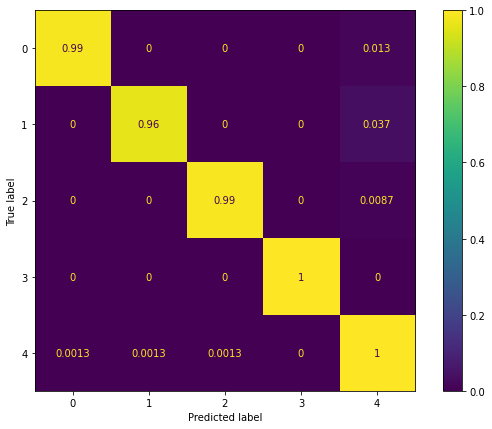

In [ ]:
best_SVM = pk.load(open(f"models/final_{best_model_name}.pkl","rb"))

plt.rcParams['figure.figsize'] = [10, 7] #inches


metadata_matrix = metadata_matrix_generator(ovo, ovr, sup_test_data,)  # Creation of metadata matrix

CM = sklearn.metrics.confusion_matrix(sup_test_label, best_SVM.predict(metadata_matrix), normalize='true') # Normalized on rows

print(len(SVM.classes_))
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=CM)
disp.plot()
plt.show()

## 1.3 Superclass division and Feature Reduction

In [ ]:
superclasses_data = []
superclasses_labels = []


for i in range(numberOfSuperclass):
  superclasses_data.append(miRna_data_train[superclasses == i])
  superclasses_labels.append(miRna_label_train[superclasses == i])
  
for i in range(numberOfSuperclass):
  print("\nSuperclass ",i)
  print("\tShape:",superclasses_data[i].shape)
  print(f"\t{len(np.unique(superclasses_labels[i]))} different classes:")
  for label in np.unique(superclasses_labels[i]):
    count=0
    for j in superclasses_labels[i]:
      if j == label:
        count =count+1
    
    print(f"\t{label} = {count}")
  




Superclass  0
	Shape: (766, 1881)
	24 different classes:
	BLCA = 54
	BRCA = 9
	CESC = 13
	CHOL = 2
	COAD = 10
	ESCA = 2
	HNSC = 99
	KICH = 4
	KIRC = 2
	KIRP = 13
	LIHC = 66
	LUAD = 2
	LUSC = 17
	OV = 1
	PAAD = 19
	PCPG = 3
	PRAD = 349
	READ = 17
	SARC = 5
	SKCM = 7
	STAD = 34
	THCA = 5
	UCEC = 32
	UCS = 1

Superclass  1
	Shape: (408, 1881)
	13 different classes:
	BLCA = 5
	BRCA = 51
	COAD = 3
	ESCA = 3
	KICH = 1
	KIRC = 283
	LGG = 1
	OV = 48
	PCPG = 3
	SARC = 2
	THCA = 3
	THYM = 1
	UCEC = 4

Superclass  2
	Shape: (3442, 1881)
	33 different classes:
	ACC = 31
	BLCA = 126
	BRCA = 364
	CESC = 206
	CHOL = 12
	COAD = 239
	DLBC = 6
	ESCA = 33
	GBM = 1
	HNSC = 245
	KICH = 59
	KIRC = 88
	KIRP = 217
	LAML = 77
	LGG = 58
	LIHC = 114
	LUAD = 164
	LUSC = 141
	MESO = 18
	OV = 203
	PAAD = 110
	PCPG = 37
	PRAD = 3
	READ = 91
	SARC = 69
	SKCM = 101
	STAD = 190
	TGCT = 2
	THCA = 115
	THYM = 3
	UCEC = 279
	UCS = 37
	UVM = 3

Superclass  3
	Shape: (411, 1881)
	6 different classes:
	GBM = 1
	LGG = 256
	L

Feature Selection

In [ ]:
%%capture
!pip install skfeature-chappers

In [ ]:
# Feature reduction method (PCA or Fisher)
method = "PCA"

In [ ]:
from skfeature.function.similarity_based import fisher_score

superclasses_FR = []
pcas = []
selected_features = []
if(method == "fisher"):
  # Feature reduction using Fisher Score to each superclass
  for i in range(numberOfSuperclass):
    data = superclasses_data[i]
    labels = superclasses_labels[i]
    idx = fisher_score.fisher_score(data, labels, mode='rank')
    num_fea = 300     
    idx = idx[0:num_fea]
    selected_features.append(idx)
    print(idx)
    selected_features_train = data[:, idx]	   
    # Saving the reduced data
    superclasses_FR.append(selected_features_train)  

   #PCA
if(method == "PCA"):
  for i in range(numberOfSuperclass):
    data = superclasses_data[i]
    labels = superclasses_labels[i]
    pca = make_pipeline(StandardScaler(), PCA(n_components=0.95))
    transformed = pca.fit_transform(data, labels)
    pcas.append(pca)
    print(transformed.shape)
    superclasses_FR.append(transformed) 

(766, 415)
(408, 284)
(3442, 986)
(411, 273)
(3838, 945)


In [ ]:
for i in range(numberOfSuperclass):
  print(superclasses_FR[i].shape)
  # Check all is done good
  assert np.isnan(superclasses_FR[i]).sum() == 0

(766, 415)
(408, 284)
(3442, 986)
(411, 273)
(3838, 945)


## 1.4 Data division for CNN training

In [ ]:
folder_name= 'data-knn2'

In [ ]:
!rm -r ./$folder_name/
!mkdir ./$folder_name/

rm: cannot remove './data-knn2/': No such file or directory


In [ ]:
for i in range(numberOfSuperclass):
  !mkdir ./$folder_name/superclass{i}
!ls $folder_name

superclass0  superclass1  superclass2  superclass3  superclass4


In [ ]:
#Export arrays
from numpy import asarray
from numpy import savetxt

for i in range(numberOfSuperclass):
    savetxt(f'{folder_name}/superclass{i}/data.csv', superclasses_FR[i], delimiter=',')
    savetxt(f'{folder_name}/superclass{i}/labels.csv', superclasses_labels[i], delimiter=',', fmt='%s')


In [ ]:
if(method=="fisher"):
  for i in range(numberOfSuperclass):
    savetxt(f"./{folder_name}/superclass{i}/selected_features.csv", selected_features[i], delimiter=',', fmt='%s')
else:
  for i in range(numberOfSuperclass):
      pk.dump(pcas[i], open(f"models/pca_superclass_{i}.pkl","wb"))

In [ ]:
# Save the dictionary containing the mapping
import json 
for i in range(numberOfSuperclass):
  d = create_dictionary(superclasses_labels[i])
  with open(f"./{folder_name}/superclass{i}/label_mapping_dict.json","w") as fout:
    json.dump(d, fout, indent = 4)

In [ ]:
# Export of dataset info 
string = "Dataset info:\n"
string = string + f"-Created using {preprocessing} and {method} feature reduction \n"
string = string + "\n\t\t ---------------------- \n"

for i in range(numberOfSuperclass):
  string = string + f"\t\tSUPERCLASS {i}\n"
  string = string + f"Size = {superclasses_FR[i].shape[0]}\n"
  string = string + f"Total of {len(np.unique(superclasses_labels[i]))}" + f" classes:\n{(np.unique(superclasses_labels[i]))}\n"
  string = string + "\t\t ---------------------- \n"
print(string)
with open(f'{folder_name}/info.txt', 'w') as f:
    f.write(string)



Dataset info:
-Created using KMeans + RAW + RFC and PCA feature reduction 

		 ---------------------- 
		SUPERCLASS 0
Size = 766
Total of 24 classes:
['BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'ESCA' 'HNSC' 'KICH' 'KIRC' 'KIRP'
 'LIHC' 'LUAD' 'LUSC' 'OV' 'PAAD' 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM'
 'STAD' 'THCA' 'UCEC' 'UCS']
		 ---------------------- 
		SUPERCLASS 1
Size = 408
Total of 13 classes:
['BLCA' 'BRCA' 'COAD' 'ESCA' 'KICH' 'KIRC' 'LGG' 'OV' 'PCPG' 'SARC' 'THCA'
 'THYM' 'UCEC']
		 ---------------------- 
		SUPERCLASS 2
Size = 3442
Total of 33 classes:
['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD'
 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC'
 'UCS' 'UVM']
		 ---------------------- 
		SUPERCLASS 3
Size = 411
Total of 6 classes:
['GBM' 'LGG' 'LUSC' 'OV' 'TGCT' 'UCEC']
		 ---------------------- 
		SUPERCLASS 4
Size = 3838
Total of 33 classes:
['ACC' 'BLCA' 'BRCA' 'CE

# 2. PAPER

## 2.0 Dataset readataptation using classes from paper

In [ ]:
labels = ['BLCA', 'KIRC', 'SKCM', 'UCEC', 'UVM', 'ACC', 'BRCA', 'CHOL', 'DLBC', 'ESCA', 'LIHC', 'PCPG', 'HNSC', 'KIRP', 'LGG', 'LUSC', 'MESO', 'TGCT', 'CESC', 'KICH', 'LUAD', 'PAAD', 'PRAD', 'THYM','FPPP', 'SARC', 'UCS', 'STAD', 'THCA']

new_miRna_label = []
new_miRna_data = []

for idx, label in enumerate(miRna_label):
  if label in labels:
    new_miRna_data.append(miRna_data[idx])
    new_miRna_label.append(label)

new_miRna_label = np.array(new_miRna_label)
new_miRna_data = np.array(new_miRna_data)
print("Paper-dataset size: ", new_miRna_data.shape)

Paper-dataset size:  (9760, 1881)


## 2.1 Training and test division

In [ ]:
from numpy import asarray
from numpy import savetxt

new_miRna_data = scipy.stats.zscore(new_miRna_data, axis=None)

# Data train and test division for inference
save = False
train_data, test_data, train_label, test_label = train_test_split(new_miRna_data, new_miRna_label, stratify=new_miRna_label, test_size=test_size, random_state=random_state)

miRna_data_train = train_data
miRna_label_train = train_label

print("Train data dimensions:", train_data.shape)
print("Test data dimensions:", test_label.shape)

print(f"Number of unique classes train:{len(np.unique(train_label))}")
print(f"Number of unique classes test:{len(np.unique(test_label))}")

# Saving the splitted dataset
if save == True:
  savetxt(f'train_test/train_data_paper.csv', train_data, delimiter=',')
  savetxt(f'train_test/train_label_paper.csv', train_label, delimiter=',', fmt='%s')
  savetxt(f'train_test/test_data_paper.csv', test_data, delimiter=',')
  savetxt(f'train_test/test_label_paper.csv', test_label, delimiter=',', fmt='%s')



Train data dimensions: (7808, 1881)
Test data dimensions: (1952,)
Number of unique classes train:28
Number of unique classes test:28


## 2.2 Superclass division

In [ ]:
superclass_division = {
    0:['BLCA', 'KIRC', 'SKCM', 'UCEC', 'UVM'],
    1:['ACC', 'BRCA', 'CHOL', 'DLBC', 'ESCA', 'LIHC', 'PCPG'],
    2:['HNSC', 'KIRP', 'LGG', 'LUSC', 'MESO', 'TGCT'],
    3:['CESC', 'KICH', 'LUAD', 'PAAD', 'PRAD', 'THYM'],
    4:['FPPP', 'SARC', 'UCS', 'STAD', 'THCA'] # La classe FPPP non esiste nel nostro dataset
}
miRna_superclasses = []

# Arrays for superclass data and label divisions
superclass_array = []
superclasses_labels = []
numberOfSuperclass = 5

# Data division
for i in range(numberOfSuperclass):
  superclass = []
  labels = []
  for idx, label in enumerate(miRna_label_train):
    if label in superclass_division[i]:
      superclass.append(miRna_data_train[idx])
      labels.append(label)
      miRna_superclasses.append(i)
  superclass_array.append(superclass)
  superclasses_labels.append(np.array(labels))

print("Superclasses informations:")
# for i in range(5):
#   for element in superclass_division[i]:
#     count = 0
#     for label in superclasses_labels[i]:
#       if label == element:
#         count = count+1
#     # print(f"{element} = {count}")
for i in range(numberOfSuperclass):
  print(np.unique(superclasses_labels[i]))
miRna_superclasses = np.array(miRna_superclasses)

transformed_dataset = miRna_data_train

Superclasses informations:
['BLCA' 'KIRC' 'SKCM' 'UCEC' 'UVM']
['ACC' 'BRCA' 'CHOL' 'DLBC' 'ESCA' 'LIHC' 'PCPG']
['HNSC' 'KIRP' 'LGG' 'LUSC' 'MESO' 'TGCT']
['CESC' 'KICH' 'LUAD' 'PAAD' 'PRAD' 'THYM']
['SARC' 'STAD' 'THCA' 'UCS']


In [ ]:
# Train and evaluation division for SUPERCLASS detection
train_data, evaluation_data, train_superclasses, evaluation_superclasses = train_test_split(miRna_data_train, miRna_superclasses, stratify=miRna_superclasses, test_size=test_size, random_state=random_state)

print("Train data dimensions:", train_data.shape)
print("Evaluation data dimensions:", evaluation_data.shape)


Train data dimensions: (6246, 1881)
Evaluation data dimensions: (1562, 1881)


## 2.3 Metadata creation

For the metadata creation we tried two different approaches:
1) Using SVC classificator
2) Using GBC (like the paper)

### Metadata creation using the scores from OVS/OVO with SVC


In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
def ovo_ovr_training(train_data, train_label):
  # OVO
  ovo = SVC(decision_function_shape='ovo')
  ovo.fit(train_data, train_label)
  pk.dump(ovo, open("models/ovo.pkl","wb"))
  # OVR
  ovr = SVC(decision_function_shape='ovr')
  ovr.fit(train_data, train_label)
  pk.dump(ovr, open("models/ovr.pkl","wb"))
  return ovo, ovr
  
  
# Stacking
def metadata_matrix_generator(ovo, ovr, train_data):
  ovo_scores = ovo.decision_function(train_data)
  print(ovo_scores.shape)
  ovr_scores = ovr.decision_function(train_data)
  print(ovr_scores.shape)
  
  metadata_matrix = np.hstack((ovo_scores, ovr_scores))
  print(metadata_matrix.shape)
  return metadata_matrix
 

In [ ]:
# Training of OVO and OVR
ovo, ovr = ovo_ovr_training(train_data, train_superclasses)

# Creation of metadata matrix
metadata_matrix = metadata_matrix_generator(ovo, ovr, train_data)

# Random forest training
rfc = RandomForestClassifier()
rfc.fit(metadata_matrix, train_superclasses)


(6246, 10)
(6246, 5)
(6246, 15)


RandomForestClassifier()

In [ ]:
pk.dump(rfc, open("models/randomforest.pkl","wb"))


In [ ]:
# Evaluation of the classification

ovo = pk.load(open("models/ovo.pkl",'rb'))
ovr = pk.load(open("models/ovr.pkl",'rb'))

# Test Evaluation of RFC
metadata_matrix_test = metadata_matrix_generator(ovo,ovr,evaluation_data)
predicted_labels = rfc.predict(metadata_matrix_test)
print(predicted_labels)
predicted_labels_boolean = (predicted_labels == evaluation_superclasses)
accuracy = predicted_labels_boolean.sum()/len(evaluation_superclasses) * 100
print(f"The accuracy of Random Forest classification is {accuracy}")

(1562, 10)
(1562, 5)
(1562, 15)
[1 2 1 ... 2 1 4]
The accuracy of Random Forest classification is 20.102432778489117


### OVO and OVR with Gradient Boosting (lower results than SVC)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Set to true if you want to train again

def fitting_ovo_ovr_gb(train_data, train_label, training):
  # OVO
  if training == True:
    ovo_classifier = OneVsOneClassifier(GBC())
    ovo_classifier.fit(train_data, train_label)    
    print("OVO training completed")

    pk.dump(ovo_classifier, open("models/ovo_GBC.pkl","wb"))
  else:
    ovo_classifier = pk.load(open("models/ovo_GBC.pkl",'rb'))
    print("OVO model loaded")
  ovo_ovr = list(ovo_classifier.estimators_)

  # OVR
  if training == True:
    classifier = OneVsRestClassifier(GBC(loss='exponential'))
    classifier.fit(train_data, train_label)
    print("OVR training completed")
    pk.dump(classifier, open("models/ovr_GBC.pkl","wb"))
  else: 
    classifier =  pk.load(open("models/ovr_GBC.pkl",'rb'))
    print("OVR model loaded")

  ovo_ovr = ovo_ovr + classifier.estimators_
  print(len(ovo_ovr))
  return ovo_ovr

def metadata_creation_gb(train_data, train_label, training=False):
  estimators = fitting_ovo_ovr_gb(train_data, train_label, training)

  metadata_matrix = estimators[0].predict(train_data)
  metadata_matrix = metadata_matrix.reshape((-1, 1))

  for i in range(1,len(estimators)):
    temp = estimators[i].predict(train_data)
    metadata_matrix = np.hstack((metadata_matrix, temp.reshape((-1, 1))))

  return metadata_matrix


In [ ]:
# metadata_matrix = metadata_creation(train_data, train_superclasses, training=True)
rfc = RandomForestClassifier()
rfc.fit(metadata_matrix, train_superclasses)
pk.dump(rfc, open("models/randomforest2.pkl","wb"))


#### Random Forest Classification

In [ ]:
# Evaluation of RFC
metadata_matrix_test = metadata_creation(evaluation_data, evaluation_superclasses, False)
predicted_labels = rfc.predict(metadata_matrix_test)
print(predicted_labels)
predicted_labels_boolean = (predicted_labels == evaluation_superclasses)
accuracy = predicted_labels_boolean.sum()/len(test_label) * 100
print(f"The accuracy of Random Forest classification is {accuracy}")

OVO model loaded
OVR model loaded
15
[1 0 2 ... 0 3 0]
The accuracy of Random Forest classification is 15.932377049180326


## 2.4 Feature reduction

### Feature Reduction

In [ ]:
sf = []
with open("./Selected features.csv", "r") as fin:
        reader = csv.reader(fin, delimiter=',')
        first = True
        for row in reader:
          features = []
          for el in row:  
            for e in el.split(";"):
              if e.find("Super") == -1:   
            #    print(e)
                f=e.split("-")[1]
                features.append(int(f))
            sf.append(features)

In [ ]:
superclasses_FR = []
superclass_labels_FR = []
for i in range(numberOfSuperclass):
  data = np.array(superclass_array[i])
  labels = np.array(superclasses_labels[i])
  superclasses_FR.append(data[:, sf[i]])
  print(superclasses_FR[i].shape, (superclasses_labels[i]).shape)

  print("\t", np.unique(superclasses_labels[i]))


(1731, 300) (1731,)
	 ['BLCA' 'KIRC' 'SKCM' 'UCEC' 'UVM']
(1754, 300) (1754,)
	 ['ACC' 'BRCA' 'CHOL' 'DLBC' 'ESCA' 'LIHC' 'PCPG']
(1752, 300) (1752,)
	 ['HNSC' 'KIRP' 'LGG' 'LUSC' 'MESO' 'TGCT']
(1464, 300) (1464,)
	 ['CESC' 'KICH' 'LUAD' 'PAAD' 'PRAD' 'THYM']
(1107, 300) (1107,)
	 ['SARC' 'STAD' 'THCA' 'UCS']


## 2.5 Data division for CNN training

In [ ]:
cd /content/drive/MyDrive/MLinApp_project_mine/

/content/drive/.shortcut-targets-by-id/1wXg2dci4kAWzFZAvhlShcmwk3t0dUHTP/MLinApp_project_mine


In [ ]:
folder_name= 'data-paper'

In [ ]:
!rm -r ./$folder_name/
!mkdir ./$folder_name/

In [ ]:
for i in range(numberOfSuperclass):
  !mkdir ./$folder_name/superclass{i}
!ls $folder_name

superclass0  superclass1  superclass2  superclass3  superclass4


In [ ]:
#Export arrays
from numpy import asarray
from numpy import savetxt

for i in range(numberOfSuperclass):
    savetxt(f'{folder_name}/superclass{i}/data.csv', superclasses_FR[i], delimiter=',')
    savetxt(f'{folder_name}/superclass{i}/labels.csv', superclasses_labels[i], delimiter=',', fmt='%s')


In [ ]:
# Save the dictionary containing the mapping
import json 
for i in range(numberOfSuperclass):
  d = create_dictionary(superclasses_labels[i])
  with open(f"{folder_name}/superclass{i}/label_mapping_dict.json","w") as fout:
    json.dump(d, fout, indent = 4)

In [ ]:
# Export of dataset info 
string = "Dataset info:\n"
string = string + "-Training dataset created from Paper Division\n"
string = string + "\n\t\t ---------------------- \n"

for i in range(numberOfSuperclass):
  string = string + f"\t\tSUPERCLASS {i}\n"
  string = string + f"Size = {superclasses_FR[i].shape[0]}\n"
  string = string + f"Total of {len(np.unique(superclasses_labels[i]))}" + f" classes:\n{(np.unique(superclasses_labels[i]))}\n"
  string = string + "\t\t ---------------------- \n"
print(string)
with open(f'{folder_name}/info.txt', 'w') as f:
    f.write(string)



Dataset info:
-Training dataset created from Paper Division

		 ---------------------- 
		SUPERCLASS 0
Size = 1731
Total of 5 classes:
['BLCA' 'KIRC' 'SKCM' 'UCEC' 'UVM']
		 ---------------------- 
		SUPERCLASS 1
Size = 1754
Total of 7 classes:
['ACC' 'BRCA' 'CHOL' 'DLBC' 'ESCA' 'LIHC' 'PCPG']
		 ---------------------- 
		SUPERCLASS 2
Size = 1752
Total of 6 classes:
['HNSC' 'KIRP' 'LGG' 'LUSC' 'MESO' 'TGCT']
		 ---------------------- 
		SUPERCLASS 3
Size = 1464
Total of 6 classes:
['CESC' 'KICH' 'LUAD' 'PAAD' 'PRAD' 'THYM']
		 ---------------------- 
		SUPERCLASS 4
Size = 1107
Total of 4 classes:
['SARC' 'STAD' 'THCA' 'UCS']
		 ---------------------- 

